# Support Vector Machine

In this section a support vector machine algorithm will be developed to predict the costumer data more probable to comply in the next campaing. This algorithm is pretty interesting considering that it is capable of building the analytical solution for the best classifier, considering the provided dataset. Unfortunatly this approach I will use the `sklearn` library which does not provide a analytical solution of the support vector machines, instead it uses some iterative technique to determine the best model parameters, and this brings the model close of what it would be if it were analitically solved. But even though it usually get some interesting results. Therefore, here is the implementation:

## Reading the DataSet

In [1]:

import pandas as pd

data_path = './ifood-data-business-analyst-test/ml_project1_data.csv'
dataset = pd.read_csv(data_path)


## Preprocessing 

> Realise that this preprocessing is very close to the one presented before with in the XGBoost technique, therefore, if one wants to jump this part to the model part, please go for it.

Here we need to provide a simple preprocess to the data to remove possible non informative data, to create information fields that are more suitable for interpretation, some encoding of the features (since some are categorical), also we will make some normalization on the data to avoid over weighting errors and so on... 

> Notice that most functions to do the preprocessing here are implemented in a separated code, since it could be used for other models, and for later analysis.

In [2]:
from utils import *

### Pipeline

The preprocessing pipeline, for the XGBoost classification algorithm will be the one, as follows:

- `Step #1` First we will replace some fields with more interpretable information (Birth date => Age, Customer Registration => Persistence, ...)

- `Step #2` Then we are going to replace the categorical data set with an encoded one (categorical variables => numerical variables)

- `Step #3` Then some non informative features will be dropped from the analysis, _e.g._ features that are constant in all samples (which does not provide any information)

- `Step #4` Since we have only 24 samples with NaN (or null) values, we can drop those from the dataset, instead of concerning with interpolation and so on...

In [3]:

dataset = support.replaceFields(dataset)                # Step #1

dataset, encoders = support.encodeDataSet(dataset)      # Step #2

dataset = support.dropNonInformative(dataset)           # Step #3

df = dataset.dropna()                           # Step #4


Features dropped: ['Z_CostContact', 'Z_Revenue']


Here we have some particular processing of the data for this particular Support Vector Machines model. Even though this model has analytical solution, it also uses an stochastic searcher to find its best parameters... The same way that the XGBoost algorithm. Thence, both the normalization and the data balancing will be done the same way that in the XGBoost algorithm. If one wants to understand why we use those here, please check out the XGBoost section.

In summary, we will first build the regression problem as something close to the structure:

$$y(k) = f(\phi(k), \theta)$$

After we can normalize the data, by just making it fit the the group $[0, 1]$. After the normalization we do some data balancing, the same way as discussed in the XGBoost section.

In [4]:

import numpy as np

# Create the regression format
phi = df.loc[:, ~df.columns.isin(['Response', 'ID'])].to_numpy()
target = df["Response"].to_numpy()

# Normalization
max_vals = np.amax(phi, axis=0)
min_vals = np.amin(phi, axis=0)
phi_n = (phi - max_vals) / (max_vals - min_vals)

# Balancing the data
X, y = support.balanceDataSet(phi_n, target)


### Train and Test data

Here we simply use the data to build the train and test sets:

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)


## Train model

Here we create and train the model using the soo called Support Vector Machine (_secret: my secret love!! Hehe_). This algorithm is pretty interesting because if mess around with its math, it can became any one that you want... It has math flexibility to became a decision tree, or a deep network... Any model at all!! If one wants to understand the math behind it I advice to check out one of my papers at the [iFac Internation Congress](https://www.sciencedirect.com/science/article/pii/S2405896318328271?via%3Dihub) or my book chapter where I discuss even better [IET Digital Library](https://digital-library.theiet.org/content/books/10.1049/pbce123e_ch3;jsessionid=ji7b4180pudn.x-iet-live-01). 

This algorithm is pretty good, but when it is solved analitically! Therefore, this algorithm always will find the best classifier for the dataset, provided its hyper parameters, when it is solved analitically. Unfortunatelly, the libraries that provide a simple API to access this model, usually use some stochastic searcher and usually find the model by computational iterations, which limits the algorithm on its solution... If one desires I can provide a math explanation later Haha. But it is enoguh to know that the parameter `max_iter` is responsible to control how much iterations the model is allow to try to go as close as it can to the analitical solution.

The analical solution usually depend on the solution of the following Lagrangian equation:

$$L(E,\theta, \lambda) = \frac{1}{2} \theta^\top \theta + \frac{\gamma}{2}E^\top E - \lambda^\top \left(E - Y + \Phi \theta \right)$$

Which is actually the following:

$$\lambda = \left(\frac{I_{(n_x)}}{\gamma} + \Phi \Phi^\top \right)^{-1} Y$$

Note that the reason that the analytical solution is not used by those libraries, is related to the inverse of the $\Phi$ which does not always exists... it actually depends on the amount of noise on the input data (features). Therefore, we must satisfy ourselfs with the computational solution provided by the sklearn library, for example.

Here we use a grid search technique to find the best hyper parameters for the model the `C` and `gamma` (respectivally the `C` is actually the $\gamma$ in the above equations, mathematicians actually prefere that `C`=$\gamma$ and `gamma`=$\sigma$).

In [6]:

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create the hyper parameter candidates
candidates = dict(C = np.logspace(-3, 4, 40),
                  gamma = np.logspace(-7, 2, 40))

# Build the model
model = SVC(max_iter=200)

# Build the grid search on the candidates
clf = GridSearchCV(model, candidates)
# Train the model considering the candidates
search = clf.fit(X_train, y_train)

# Select the best model
model = search.best_estimator_


In [7]:
search.best_params_

{'C': 1266.380173467402, 'gamma': 0.0014251026703029992}

Here we also present a version unsing the annealing algorithm presented in the on the XGBoost section. To show that both algorithms are good enough to determine the paramters, once that the grid search has a high resolution grid. I don't need to show, but the annealing version is better then the grid search one, since it find the global minimun, therefore the set of hyper parameters that makes this model more close to the best classifier. While the grid search will just provide the best one of the candidates of the grid.

In [8]:

# Create the parameters bounds
lower, upper = [1e-07, 1e-07], [1e5, 1e3]
bounds = zip(lower, upper)

# Run the annealing search to determine the hyper parameters
pars, res = support.svmHyperGridSearch(bounds, (y_train, X_train, y_test, X_test))

# Build and train the model with the best parameters
model = SVC(C=pars[0], gamma=pars[1], max_iter=2000)
model.fit(X_train, y_train)


SVC(C=14386.055129815519, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=3.275594178351446,
    kernel='rbf', max_iter=2000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Model Results

Then here we can build some visualizations to show the results. The first one is the fitting with the testing data, using the confusion matrix to make sure the model is consistent. 

> Remember that this data set is balanced, and therefore is a more honnest result, then the second one that will be shown.

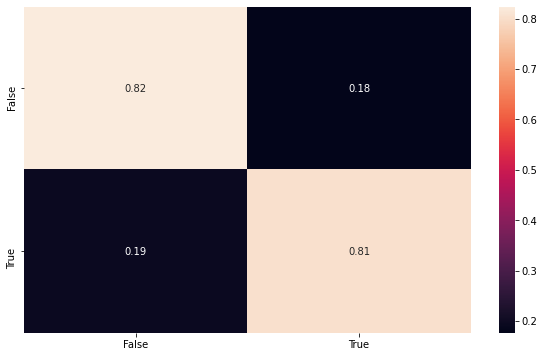

In [9]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

index = ['False','True']  
cm_df = pd.DataFrame(conf_mat,index,index)                      

plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)


Here we can show the classification performance of the unbalaced dataset, using all samples, to be sure that the model maintain its consistency.

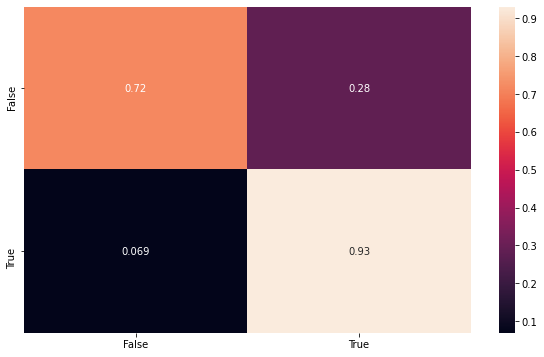

In [10]:

y_pred = model.predict(phi_n)
conf_mat = confusion_matrix(target, y_pred, normalize='true')

index = ['False','True']  
cm_df = pd.DataFrame(conf_mat,index,index)                      

plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)
